In [1]:
from jax.config import config; config.update("jax_enable_x64", True)
from jax.random import PRNGKey, split
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from collapse import compute_feature_collapse, best_fit_line
from network import init_net_orth, compute_outputs
from loss import create_loss
from solver import train
from data import generate_orthogonal_input, generate_labels_and_target

## Intro Figure

In [2]:
key = PRNGKey(0)

num_classes = 5
num_samples_per_class = 10
total_samples = num_classes * num_samples_per_class
input_dim = total_samples

labels, target = generate_labels_and_target(num_classes, num_samples_per_class)

key, subkey = split(key)
input_data = generate_orthogonal_input(subkey, input_dim, total_samples)

depth = 8
init_scale = 0.5

loss_fn = create_loss(target)

def linear_e2e_loss_fn(weights):
    return loss_fn(compute_outputs(weights, input_data, nonlinear=False)[0])

def nonlinear_e2e_loss_fn(weights):
    return loss_fn(compute_outputs(weights, input_data, nonlinear=True)[0])

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=num_classes, 
    width=input_dim, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-6
n_outer_loops = 5000
n_inner_loops = 100
step_size = 1

In [3]:
linear_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=linear_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops
)

linear_final_weights = linear_result['final_weights']

  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
nonlinear_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=nonlinear_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops
)

nonlinear_final_weights = nonlinear_result['final_weights']

  0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
linear_intermediate_outputs = compute_outputs(linear_final_weights, input_data, nonlinear=False)[1]

linear_feature_collapse_per_layer = jnp.array([
    compute_feature_collapse(inter_out, labels) for inter_out in linear_intermediate_outputs
])

nonlinear_intermediate_outputs = compute_outputs(nonlinear_final_weights, input_data, nonlinear=True)[1]

nonlinear_feature_collapse_per_layer = jnp.array([
    compute_feature_collapse(inter_out, labels) for inter_out in nonlinear_intermediate_outputs
])

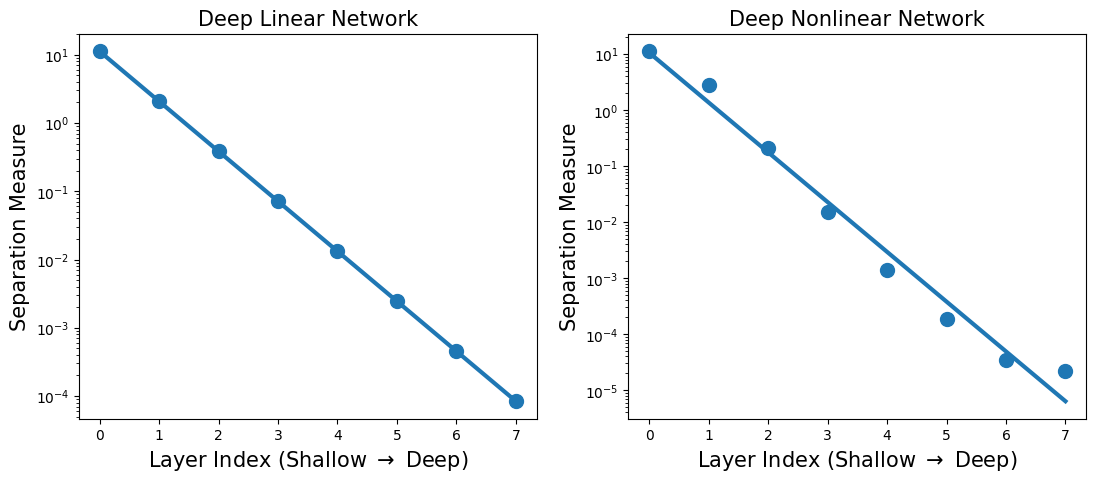

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))
axes[0].semilogy(best_fit_line(linear_feature_collapse_per_layer), c='tab:blue', linewidth=3)
axes[0].semilogy(linear_feature_collapse_per_layer, 'o', c='tab:blue', markersize=10)
axes[0].set_xlabel(r'Layer Index (Shallow $\rightarrow$ Deep)', fontsize=15)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Separation Measure', fontsize=15)
axes[0].set_title('Deep Linear Network', fontsize=15)

axes[1].semilogy(best_fit_line(nonlinear_feature_collapse_per_layer), c='tab:blue', linewidth=3)
axes[1].semilogy(nonlinear_feature_collapse_per_layer, 'o', c='tab:blue', markersize=10)
axes[1].set_xlabel(r'Layer Index (Shallow $\rightarrow$ Deep)', fontsize=15)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Separation Measure', fontsize=15)
axes[1].set_title('Deep Nonlinear Network', fontsize=15);

plt.savefig('figs/collapse_intro.png', dpi=300, bbox_inches='tight')